In [ ]:
import numpy as np 
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import lightgbm as lgb, xgboost as xgb, catboost as cb
from gc import collect
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

: 

In [ ]:
train_df = pd.read_excel('notebook\data\TRAIN_NEW\TRAIN_CATEGORICAL_METADATA_new.xlsx')
fmri = pd.read_csv('notebook\data\TRAIN_NEW\TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
quant_df = pd.read_excel('notebook\data\TRAIN_NEW\TRAIN_QUANTITATIVE_METADATA_new.xlsx')
train_sols = pd.read_excel('notebook\data\TRAIN_NEW\TRAINING_SOLUTIONS.xlsx')

train_df = train_df.merge(fmri,on='participant_id',how = 'left')
train_df = train_df.merge(quant_df,on='participant_id',how = 'left')
train_df = train_df.merge(train_sols,on='participant_id',how = 'left')


train_df.head()



,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,...,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,ADHD_Outcome,Sex_F
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN,...,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127,1,0
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0,...,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN,1,0
2,04X1eiS79T4B,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN,...,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381,0,1
3,05ocQutkURd6,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0,...,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553,0,1
4,06YUNBA9ZRLq,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN,...,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574,1,0


In [ ]:
test_df = pd.read_csv('notebook\data\TEST\TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')
test_cat = pd.read_excel('notebook\data\TEST\TEST_CATEGORICAL.xlsx')
quant_df = pd.read_excel('notebook\data\TEST\TEST_QUANTITATIVE_METADATA.xlsx')


test_df = test_df.merge(test_cat,on = 'participant_id',how = 'left')
test_df = test_df.merge(quant_df,on = 'participant_id',how = 'left')

test_df.head()

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,Cfwaf5FX7jWK,0.548480,0.713607,0.557319,0.524369,0.693364,0.770032,0.724406,0.390118,0.547912,...,2.0,12.0,3.0,9.0,2.0,7.0,3.0,0.0,8.0,8.992813
1,vhGrzmvA3Hjq,0.427740,0.363022,0.402862,0.363003,0.534558,0.345347,0.409471,0.303328,0.402515,...,2.0,16.0,8.0,5.0,7.0,3.0,11.0,3.0,9.0,12.324093
2,ULliyEXjy4OV,0.139572,0.390106,-0.087041,0.196852,0.088148,0.023843,0.381782,0.068979,0.377488,...,1.0,7.0,1.0,6.0,1.0,5.0,1.0,0.0,9.0,7.770933
3,LZfeAb1xMtql,0.133561,0.778326,0.416355,0.471840,0.568460,0.633660,0.501113,0.345461,0.467943,...,4.0,15.0,4.0,10.0,8.0,6.0,5.0,1.0,6.0,9.304814
4,EnFOUv0YK1RG,0.126699,0.575446,0.509422,0.363193,0.427544,0.449924,0.451796,0.223927,0.298248,...,2.0,18.0,6.0,12.0,5.0,10.0,6.0,0.0,10.0,8.261350


In [8]:
y = pd.read_excel('/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx')

In [9]:
train_df.set_index('participant_id', inplace=True)
test_df.set_index('participant_id', inplace=True)



In [10]:
train_df.head()

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,0throw_1thcolumn,...,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,ADHD_Outcome,Sex_F
participant_id,,,,,,,,,,,,,,,,,,,,,
00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN,0.361339,...,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127,1,0
00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0,0.051430,...,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN,1,0
04X1eiS79T4B,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN,-0.305747,...,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381,0,1
05ocQutkURd6,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0,0.450442,...,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553,0,1
06YUNBA9ZRLq,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN,0.415220,...,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574,1,0


In [11]:
targets = ['ADHD_Outcome', 'Sex_F']
non_connectome_features = [col for col in train_df.columns if not (col.startswith('0throw') or col.startswith('1throw') or 
                                                             col.startswith('2throw') or col.startswith('3throw') or 
                                                             col.startswith('4throw') or col.startswith('5throw') or
                                                             col.startswith('6throw') or col.startswith('7throw') or
                                                             col.startswith('8throw') or col.startswith('9throw') or
                                                             col in targets)]


In [12]:
connectome_features = [col for col in train_df.columns if (col.startswith('0throw') or col.startswith('1throw') or 
                                                      col.startswith('2throw') or col.startswith('3throw') or 
                                                      col.startswith('4throw') or col.startswith('5throw') or
                                                      col.startswith('6throw') or col.startswith('7throw') or
                                                      col.startswith('8throw') or col.startswith('9throw'))]


In [13]:
print(train_df.shape)
print(test_df.shape)

(1213, 19929)
(304, 19927)


In [14]:
print(f"non connectome features : {len(non_connectome_features)}")
print(f"connectome features : {len(connectome_features)}")

non connectome features : 17982
connectome features : 1945


In [15]:
train_df.describe()

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,0throw_1thcolumn,...,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,ADHD_Outcome,Sex_F
count,1213.000000,1213.000000,1170.000000,1159.000000,1210.000000,1198.000000,1182.000000,1015.000000,991.000000,1213.000000,...,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,853.000000,1213.000000,1213.000000
mean,2017.652102,2.014839,0.435897,2.177739,2.294215,17.862270,25.545685,16.876847,30.257316,0.185265,...,2.324751,7.613787,4.103821,5.539037,4.599668,2.274917,7.740864,11.245678,0.685078,0.342951
std,1.122522,1.135147,0.693174,3.204782,0.750660,3.505608,16.757043,3.929558,13.901144,0.238481,...,2.166399,4.130399,2.808079,2.807063,3.510469,2.089041,2.094832,3.234372,0.464676,0.474891
min,2015.000000,1.000000,0.000000,0.000000,1.000000,3.000000,0.000000,3.000000,0.000000,-0.657053,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017.000000,1.000000,0.000000,0.000000,2.000000,15.000000,5.000000,15.000000,20.000000,0.028235,...,1.000000,5.000000,2.000000,4.000000,2.000000,0.000000,6.000000,8.803901,0.000000,0.000000
50%,2018.000000,1.000000,0.000000,1.000000,2.000000,18.000000,30.000000,18.000000,35.000000,0.192886,...,2.000000,8.000000,4.000000,6.000000,4.000000,2.000000,8.000000,10.739219,1.000000,0.000000
75%,2019.000000,3.000000,1.000000,2.000000,3.000000,21.000000,40.000000,21.000000,40.000000,0.358902,...,4.000000,10.000000,6.000000,8.000000,7.000000,4.000000,10.000000,13.460871,1.000000,1.000000
max,2020.000000,4.000000,3.000000,11.000000,4.000000,21.000000,45.000000,21.000000,45.000000,0.824448,...,10.000000,20.000000,10.000000,10.000000,17.000000,9.000000,10.000000,21.564453,1.000000,1.000000


In [16]:
cols = train_df.columns
missing_train_cols = []

for col in cols:
    if train_df[col].isnull().sum() > 0:
        missing_train_cols.append(col)


missing_train_cols

['PreInt_Demos_Fam_Child_Ethnicity',
 'PreInt_Demos_Fam_Child_Race',
 'MRI_Track_Scan_Location',
 'Barratt_Barratt_P1_Edu',
 'Barratt_Barratt_P1_Occ',
 'Barratt_Barratt_P2_Edu',
 'Barratt_Barratt_P2_Occ',
 'EHQ_EHQ_Total',
 'ColorVision_CV_Score',
 'APQ_P_APQ_P_CP',
 'APQ_P_APQ_P_ID',
 'APQ_P_APQ_P_INV',
 'APQ_P_APQ_P_OPD',
 'APQ_P_APQ_P_PM',
 'APQ_P_APQ_P_PP',
 'SDQ_SDQ_Conduct_Problems',
 'SDQ_SDQ_Difficulties_Total',
 'SDQ_SDQ_Emotional_Problems',
 'SDQ_SDQ_Externalizing',
 'SDQ_SDQ_Generating_Impact',
 'SDQ_SDQ_Hyperactivity',
 'SDQ_SDQ_Internalizing',
 'SDQ_SDQ_Peer_Problems',
 'SDQ_SDQ_Prosocial',
 'MRI_Track_Age_at_Scan']

In [17]:
cols = test_df.columns
missing_test_cols = []

for col in cols:
    if test_df[col].isnull().sum()>0:
        missing_test_cols.append(col)

missing_test_cols

['PreInt_Demos_Fam_Child_Ethnicity',
 'PreInt_Demos_Fam_Child_Race',
 'Barratt_Barratt_P1_Edu',
 'Barratt_Barratt_P1_Occ',
 'Barratt_Barratt_P2_Edu',
 'Barratt_Barratt_P2_Occ',
 'EHQ_EHQ_Total',
 'ColorVision_CV_Score',
 'APQ_P_APQ_P_CP',
 'APQ_P_APQ_P_ID',
 'APQ_P_APQ_P_INV',
 'APQ_P_APQ_P_OPD',
 'APQ_P_APQ_P_PM',
 'APQ_P_APQ_P_PP',
 'SDQ_SDQ_Conduct_Problems',
 'SDQ_SDQ_Difficulties_Total',
 'SDQ_SDQ_Emotional_Problems',
 'SDQ_SDQ_Externalizing',
 'SDQ_SDQ_Generating_Impact',
 'SDQ_SDQ_Hyperactivity',
 'SDQ_SDQ_Internalizing',
 'SDQ_SDQ_Peer_Problems',
 'SDQ_SDQ_Prosocial']

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, 00aIpNTbG5uh to Zye7yYRQohXi
Columns: 19929 entries, Basic_Demos_Enroll_Year to Sex_F
dtypes: float64(19925), int64(4)
memory usage: 184.4+ MB


In [19]:
from sklearn.impute import SimpleImputer

mode_imputer = SimpleImputer(strategy= 'most_frequent')
mean_imputer = SimpleImputer(strategy = 'mean')

In [20]:
train_df[missing_train_cols]= mean_imputer.fit_transform(train_df[missing_train_cols])
test_df[missing_test_cols]= mean_imputer.fit_transform(test_df[missing_test_cols])

In [21]:
train_df.isnull().sum().sum()

0

In [22]:
test_df.isnull().sum().sum()

0

### SDQ questionnaire

In [23]:
cols = train_df.columns
sdq_cols = [col for col in cols if 'SDQ' in col]
mean_values = train_df[sdq_cols].mean()


In [24]:
import seaborn as sns

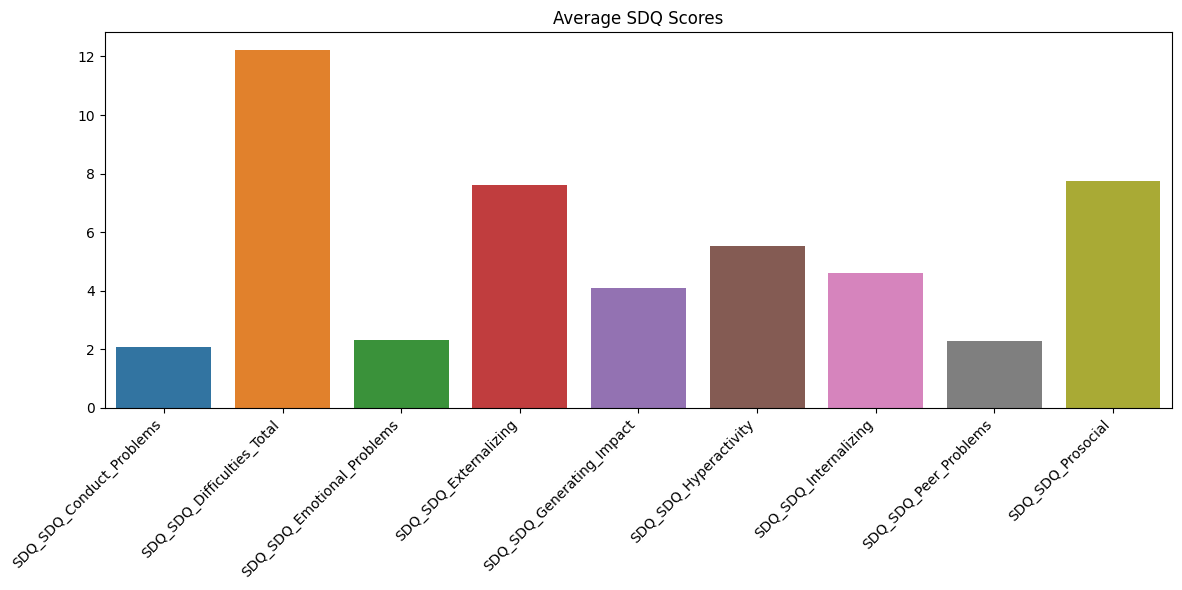

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x = mean_values.index, y = mean_values.values)
plt.title('Average SDQ Scores')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [26]:
adhd_col = 'ADHD_Outcome'
df_sdq_adhd = train_df[sdq_cols + [adhd_col]]
correlations = df_sdq_adhd.corr()[adhd_col].drop(adhd_col)



In [27]:
correlations

SDQ_SDQ_Conduct_Problems      0.274148
SDQ_SDQ_Difficulties_Total    0.462279
SDQ_SDQ_Emotional_Problems    0.204377
SDQ_SDQ_Externalizing         0.511922
SDQ_SDQ_Generating_Impact     0.408190
SDQ_SDQ_Hyperactivity         0.555685
SDQ_SDQ_Internalizing         0.255915
SDQ_SDQ_Peer_Problems         0.218099
SDQ_SDQ_Prosocial            -0.189463
Name: ADHD_Outcome, dtype: float64

In [28]:
correlations.shape

(9,)

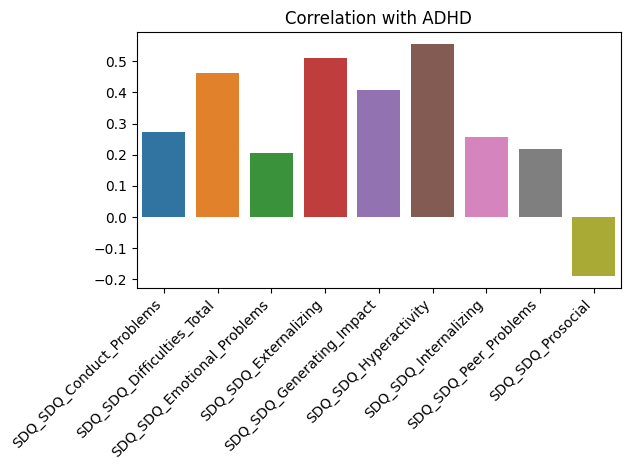

In [29]:
sns.barplot(x=correlations.index, y=correlations.values)
plt.title('Correlation with ADHD')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


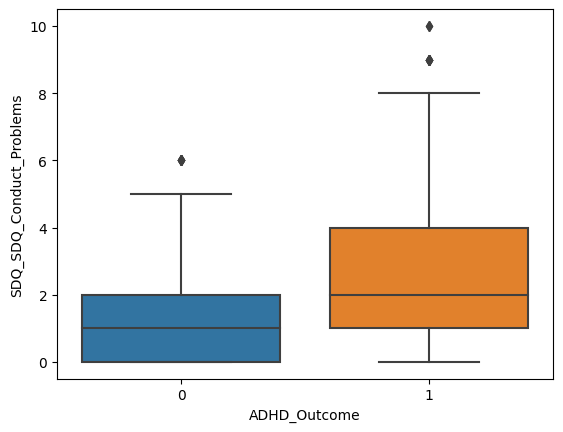

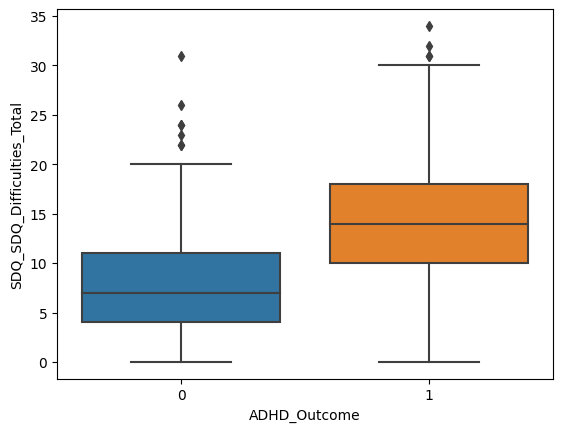

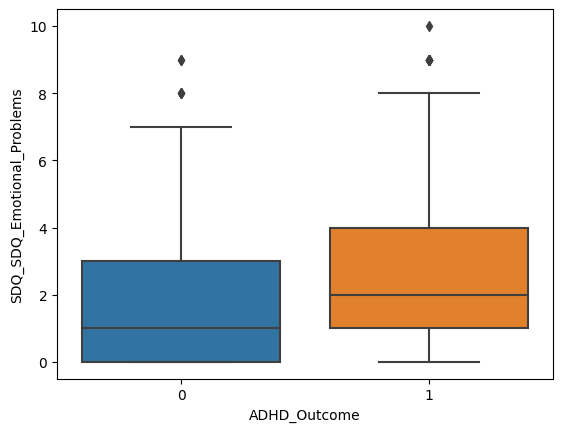

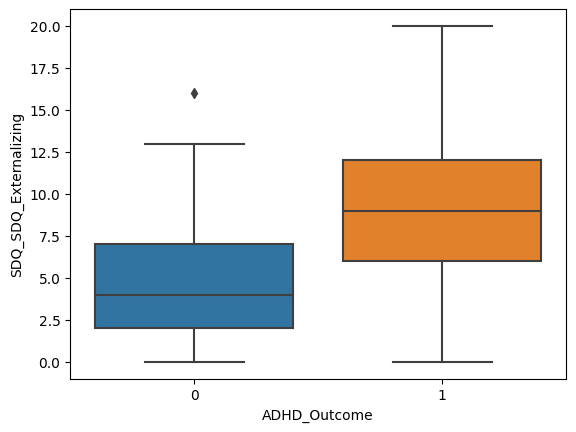

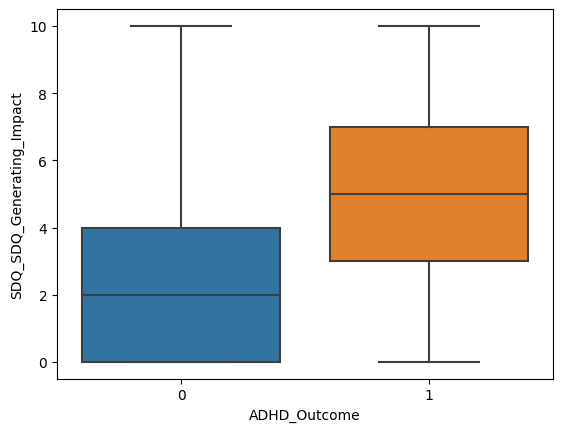

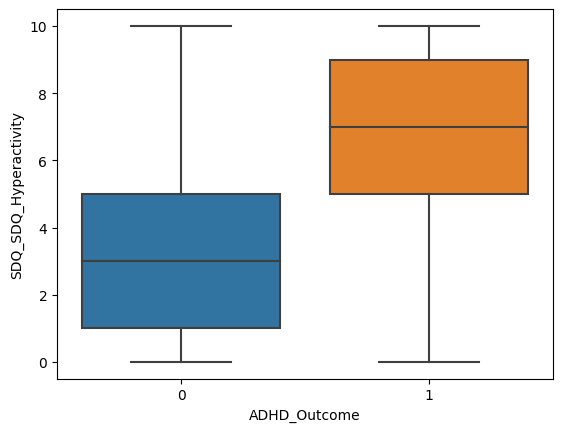

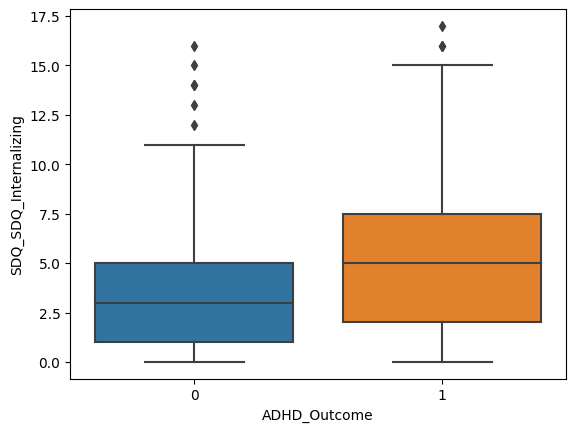

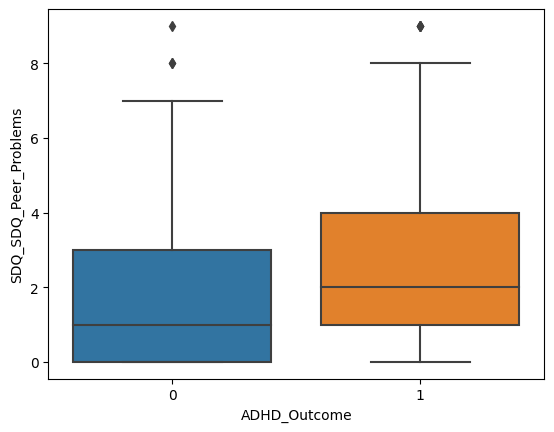

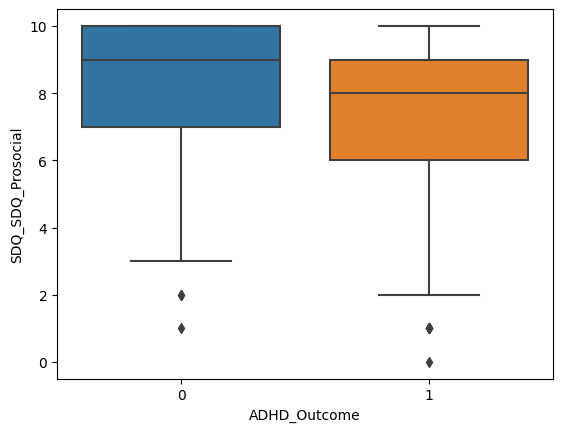

In [30]:
for col in sdq_cols:
    sns.boxplot(x = adhd_col, y = col, data = train_df)
    plt.show()

### Parenting questionanaire

In [31]:
apq_vars = [col for col in train_df.columns if 'APQ_P_APQ_P' in col]
mean_values = train_df[apq_vars].mean()
mean_values



APQ_P_APQ_P_CP      3.819317
APQ_P_APQ_P_ID     13.337219
APQ_P_APQ_P_INV    39.767694
APQ_P_APQ_P_OPD    17.963364
APQ_P_APQ_P_PM     16.557036
APQ_P_APQ_P_PP     25.498751
dtype: float64

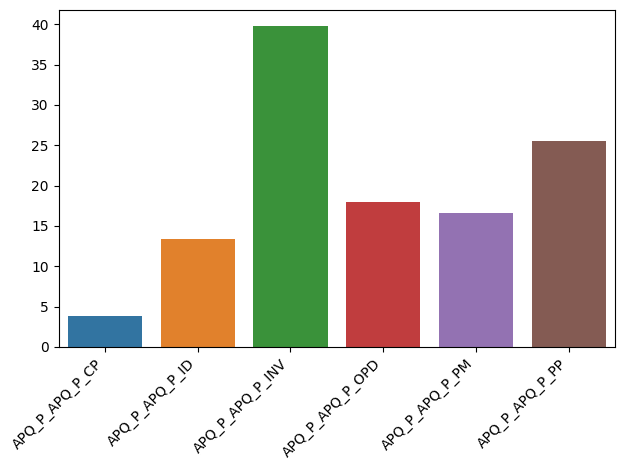

In [32]:
sns.barplot(x = mean_values.index,y = mean_values.values)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


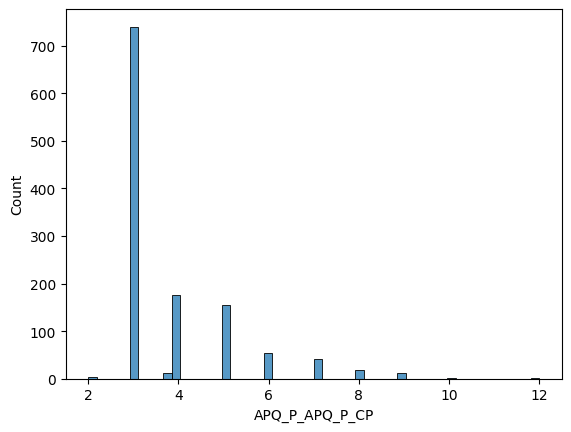

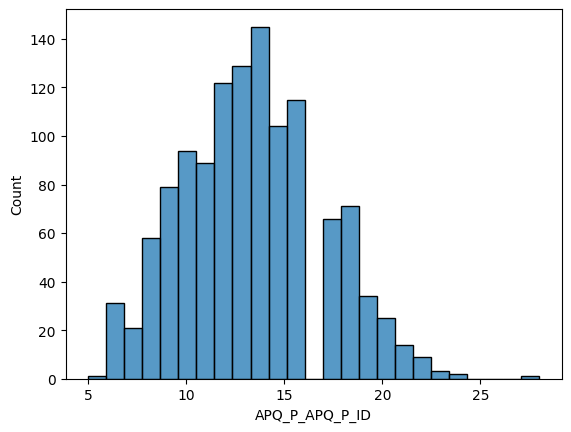

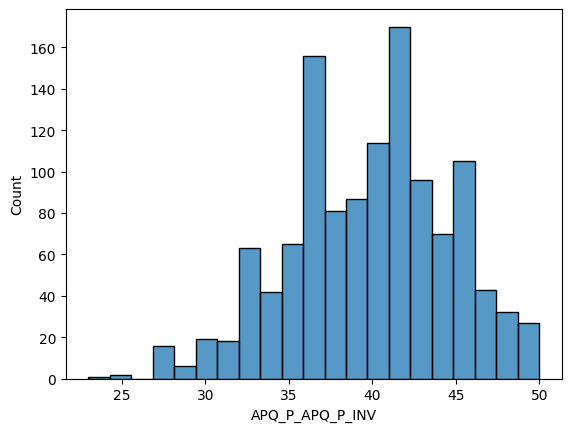

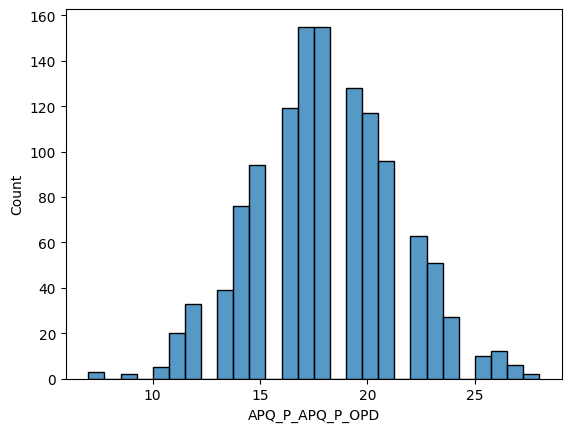

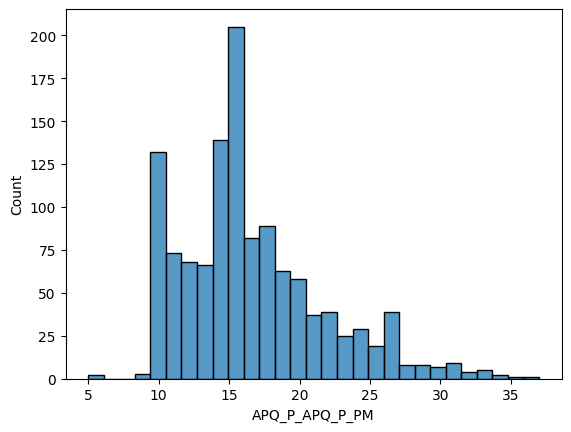

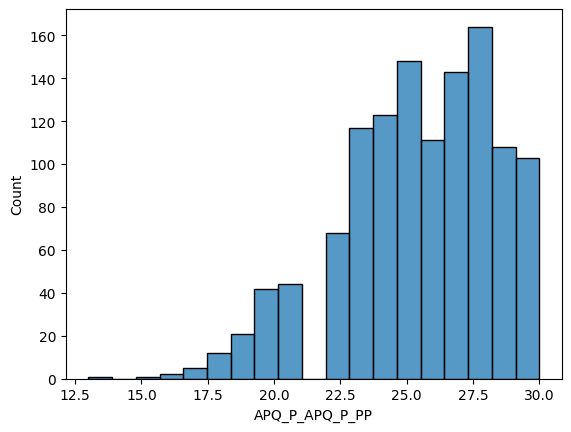

In [33]:
for col in apq_vars:
    sns.histplot(train_df[col])
    plt.show()

In [34]:
apq_adhd_corr = train_df[apq_vars + [adhd_col]]
correlation = apq_adhd_corr.corr()[adhd_col].drop(adhd_col)

In [35]:
correlation

APQ_P_APQ_P_CP     0.059104
APQ_P_APQ_P_ID     0.123544
APQ_P_APQ_P_INV   -0.098639
APQ_P_APQ_P_OPD    0.140888
APQ_P_APQ_P_PM     0.025812
APQ_P_APQ_P_PP    -0.015468
Name: ADHD_Outcome, dtype: float64

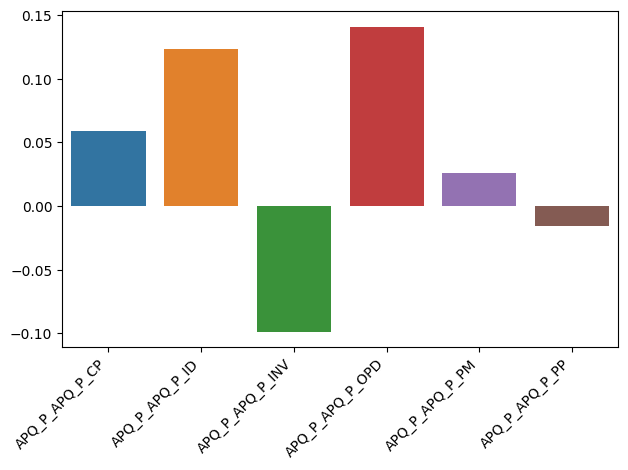

In [36]:
sns.barplot(x = correlation.index, y = correlation.values)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


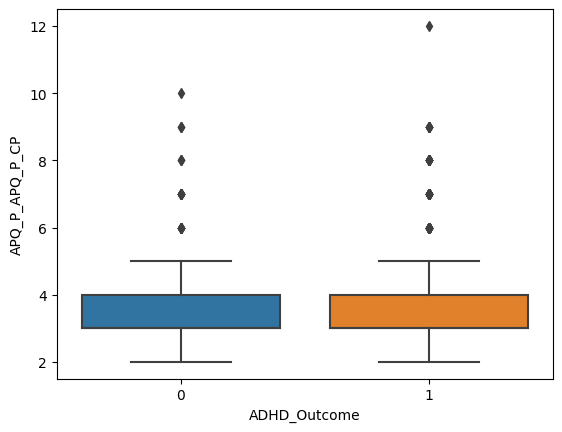

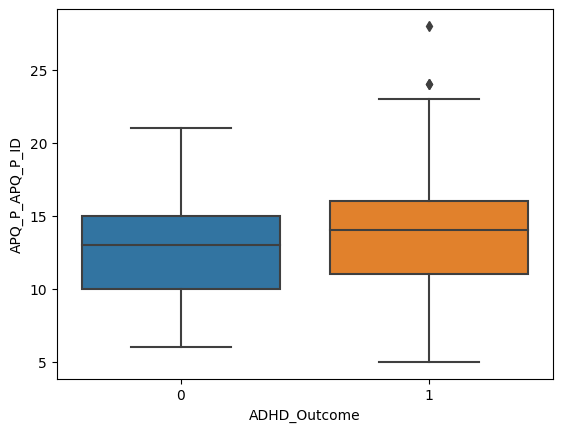

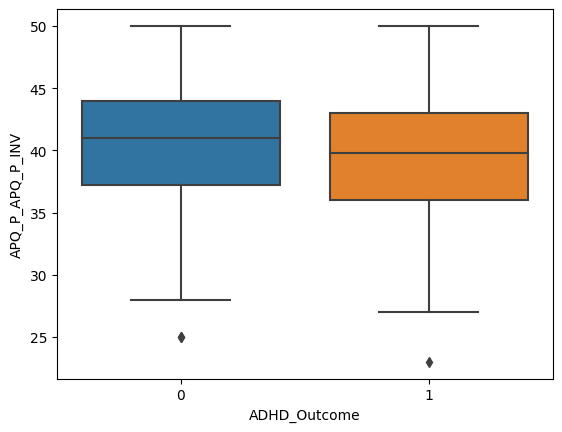

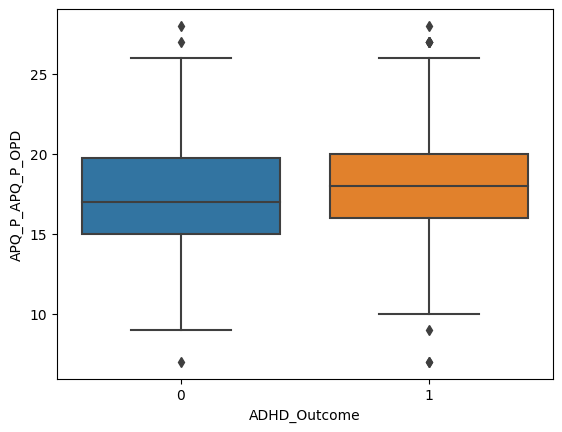

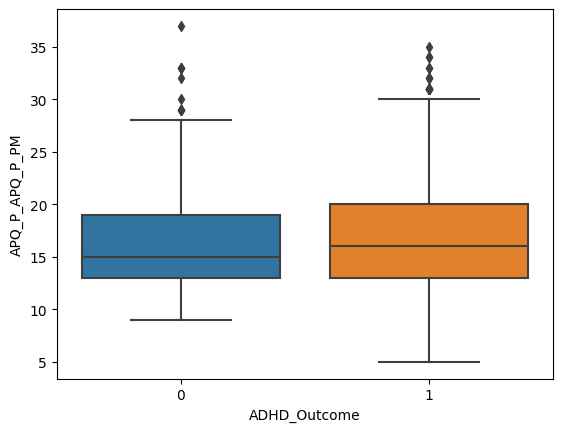

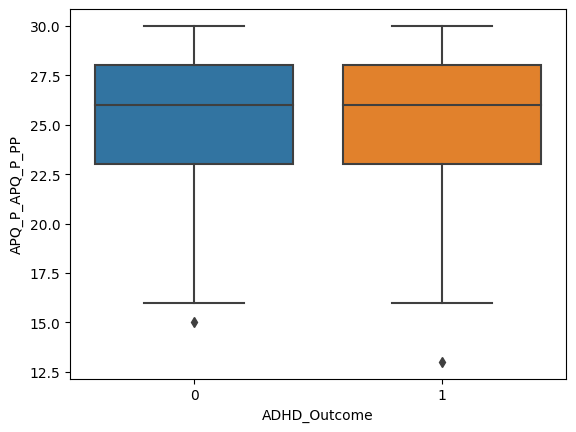

In [37]:
for col in apq_vars:

    sns.boxplot( x = adhd_col, y = col, data = train_df)
    plt.show()

### Clinical Measures

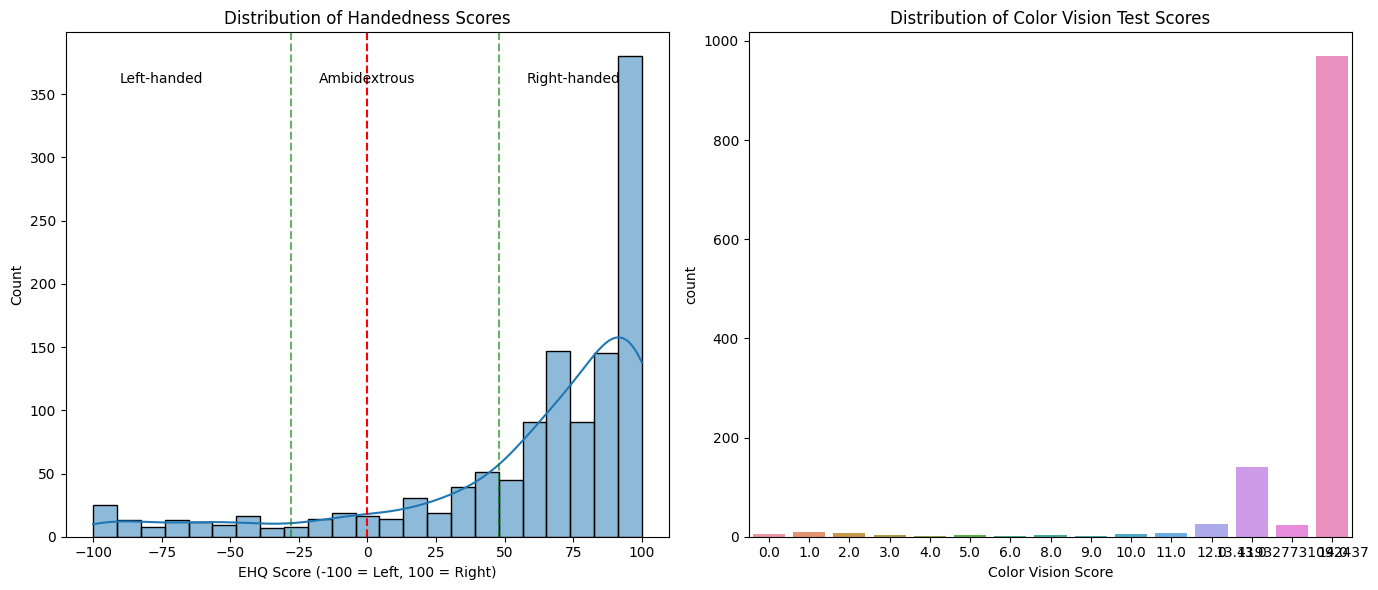

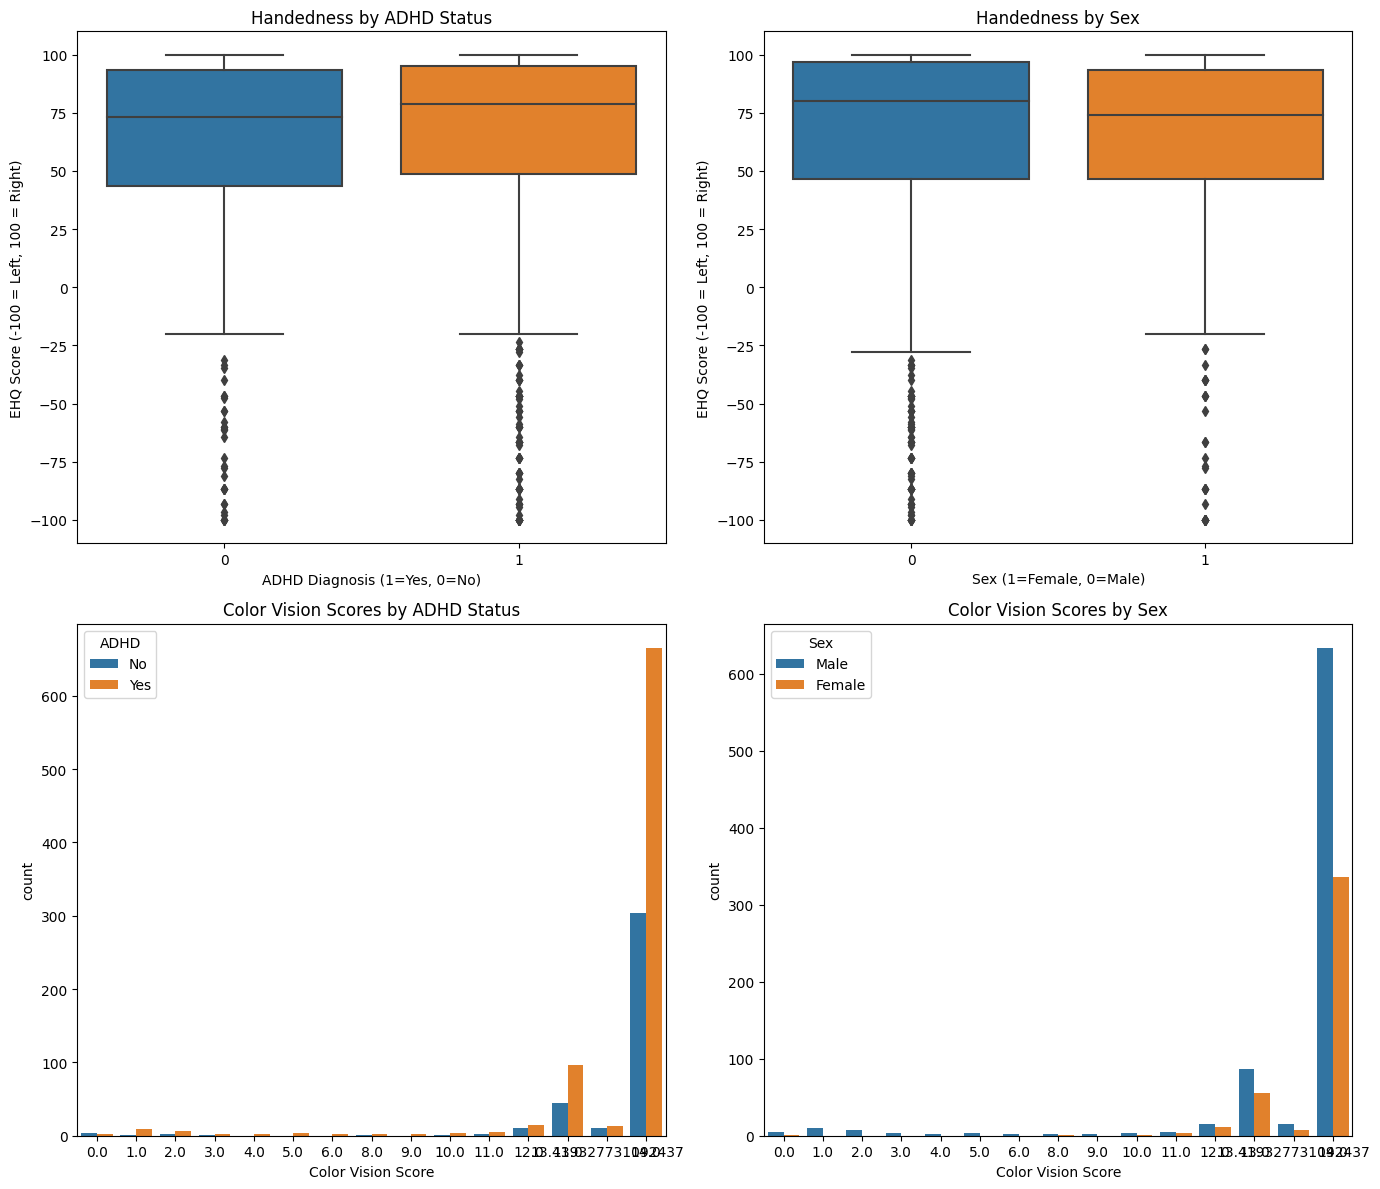

Statistical Tests for Clinical Measures:
Handedness difference by ADHD: t-stat=0.685, p-value=0.493
Handedness difference by Sex: t-stat=-0.024, p-value=0.981
Color vision association with ADHD: chi2=13.811, p-value=0.464
Color vision association with Sex: chi2=20.216, p-value=0.123


In [38]:
# Clinical Measures EDA (Handedness and Color Vision)

train = train_df
clinical_vars = ['EHQ_EHQ_Total', 'ColorVision_CV_Score']

# 1. Distribution of clinical measures
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Handedness distribution
sns.histplot(train['EHQ_EHQ_Total'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Handedness Scores')
axes[0].set_xlabel('EHQ Score (-100 = Left, 100 = Right)')
axes[0].axvline(x=0, color='r', linestyle='--')

# Add vertical lines for handedness categories
axes[0].axvline(x=-28, color='g', linestyle='--', alpha=0.6)
axes[0].axvline(x=48, color='g', linestyle='--', alpha=0.6)
# Add text for handedness regions
axes[0].text(-75, axes[0].get_ylim()[1]*0.9, 'Left-handed', ha='center')
axes[0].text(0, axes[0].get_ylim()[1]*0.9, 'Ambidextrous', ha='center')
axes[0].text(75, axes[0].get_ylim()[1]*0.9, 'Right-handed', ha='center')

# Color vision distribution
sns.countplot(x=train['ColorVision_CV_Score'], ax=axes[1])
axes[1].set_title('Distribution of Color Vision Test Scores')
axes[1].set_xlabel('Color Vision Score')

plt.tight_layout()
plt.show()

# 2. Relationship with ADHD and Sex
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Handedness by ADHD
sns.boxplot(x='ADHD_Outcome', y='EHQ_EHQ_Total', data=train, ax=axes[0, 0])
axes[0, 0].set_title('Handedness by ADHD Status')
axes[0, 0].set_xlabel('ADHD Diagnosis (1=Yes, 0=No)')
axes[0, 0].set_ylabel('EHQ Score (-100 = Left, 100 = Right)')

# Handedness by Sex
sns.boxplot(x='Sex_F', y='EHQ_EHQ_Total', data=train, ax=axes[0, 1])
axes[0, 1].set_title('Handedness by Sex')
axes[0, 1].set_xlabel('Sex (1=Female, 0=Male)')
axes[0, 1].set_ylabel('EHQ Score (-100 = Left, 100 = Right)')

# Color vision by ADHD
sns.countplot(x='ColorVision_CV_Score', hue='ADHD_Outcome', data=train, ax=axes[1, 0])
axes[1, 0].set_title('Color Vision Scores by ADHD Status')
axes[1, 0].set_xlabel('Color Vision Score')
axes[1, 0].legend(title='ADHD', labels=['No', 'Yes'])

# Color vision by Sex
sns.countplot(x='ColorVision_CV_Score', hue='Sex_F', data=train, ax=axes[1, 1])
axes[1, 1].set_title('Color Vision Scores by Sex')
axes[1, 1].set_xlabel('Color Vision Score')
axes[1, 1].legend(title='Sex', labels=['Male', 'Female'])

plt.tight_layout()
plt.show()

# 3. Statistical tests for differences
print("Statistical Tests for Clinical Measures:")

# Handedness by ADHD
from scipy.stats import ttest_ind
adhd_positive = train.loc[train['ADHD_Outcome'] == 1, 'EHQ_EHQ_Total']
adhd_negative = train.loc[train['ADHD_Outcome'] == 0, 'EHQ_EHQ_Total']
t_stat, p_val = ttest_ind(adhd_positive, adhd_negative)
print(f"Handedness difference by ADHD: t-stat={t_stat:.3f}, p-value={p_val:.3f}")

# Handedness by Sex
male = train.loc[train['Sex_F'] == 0, 'EHQ_EHQ_Total']
female = train.loc[train['Sex_F'] == 1, 'EHQ_EHQ_Total']
t_stat, p_val = ttest_ind(male, female)
print(f"Handedness difference by Sex: t-stat={t_stat:.3f}, p-value={p_val:.3f}")

# Color vision by ADHD
from scipy.stats import chi2_contingency
color_adhd_contingency = pd.crosstab(train['ColorVision_CV_Score'], train['ADHD_Outcome'])
chi2, p_val, dof, expected = chi2_contingency(color_adhd_contingency)
print(f"Color vision association with ADHD: chi2={chi2:.3f}, p-value={p_val:.3f}")

# Color vision by Sex
color_sex_contingency = pd.crosstab(train['ColorVision_CV_Score'], train['Sex_F'])
chi2, p_val, dof, expected = chi2_contingency(color_sex_contingency)
print(f"Color vision association with Sex: chi2={chi2:.3f}, p-value={p_val:.3f}")

### Brain Connectome Features

In [39]:
connectome_cols = [col for col in train.columns if (col.startswith('0throw') or 
                                                    col.startswith('1throw') or 
                                                    col.startswith('2throw'))]

sample_cols = np.random.choice(connectome_cols, 1000)


In [40]:
sample_cols

array(['0throw_82thcolumn', '1throw_116thcolumn', '0throw_139thcolumn',
       '2throw_75thcolumn', '0throw_98thcolumn', '0throw_186thcolumn',
       '1throw_49thcolumn', '0throw_93thcolumn', '0throw_161thcolumn',
       '1throw_190thcolumn', '2throw_173thcolumn', '0throw_7thcolumn',
       '2throw_191thcolumn', '0throw_6thcolumn', '1throw_57thcolumn',
       '1throw_140thcolumn', '1throw_36thcolumn', '2throw_114thcolumn',
       '1throw_26thcolumn', '0throw_120thcolumn', '1throw_179thcolumn',
       '1throw_73thcolumn', '2throw_56thcolumn', '1throw_27thcolumn',
       '1throw_168thcolumn', '0throw_1thcolumn', '0throw_38thcolumn',
       '1throw_115thcolumn', '2throw_147thcolumn', '2throw_101thcolumn',
       '2throw_83thcolumn', '1throw_93thcolumn', '1throw_150thcolumn',
       '1throw_19thcolumn', '0throw_118thcolumn', '1throw_168thcolumn',
       '2throw_148thcolumn', '1throw_3thcolumn', '2throw_184thcolumn',
       '2throw_11thcolumn', '1throw_84thcolumn', '0throw_111thcolumn',
   

In [41]:
all_values = train[sample_cols].values.flatten()


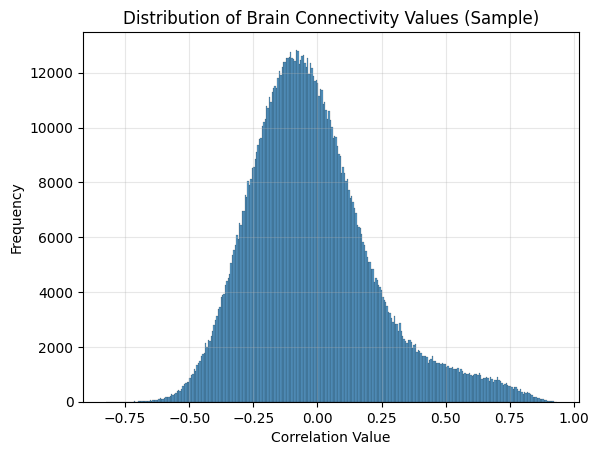

In [42]:

sns.histplot(all_values)
plt.title('Distribution of Brain Connectivity Values (Sample)')
plt.xlabel('Correlation Value')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

In [43]:
## brain connectome difference between adhd and non adhd

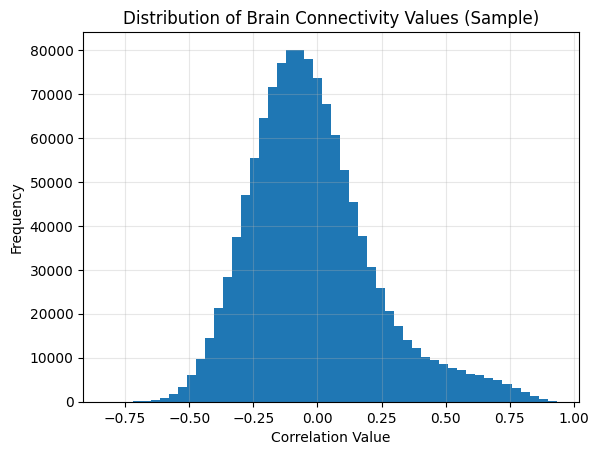

In [44]:
tiny_sample = np.random.choice(connectome_cols,20)
adhd_means = train[train['ADHD_Outcome']==1][tiny_sample].mean()
non_adhd_means = train[train['ADHD_Outcome']==0][tiny_sample].mean()
diff = adhd_means - non_adhd_means

plt.hist(all_values, bins=50)
plt.title('Distribution of Brain Connectivity Values (Sample)')
plt.xlabel('Correlation Value')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()



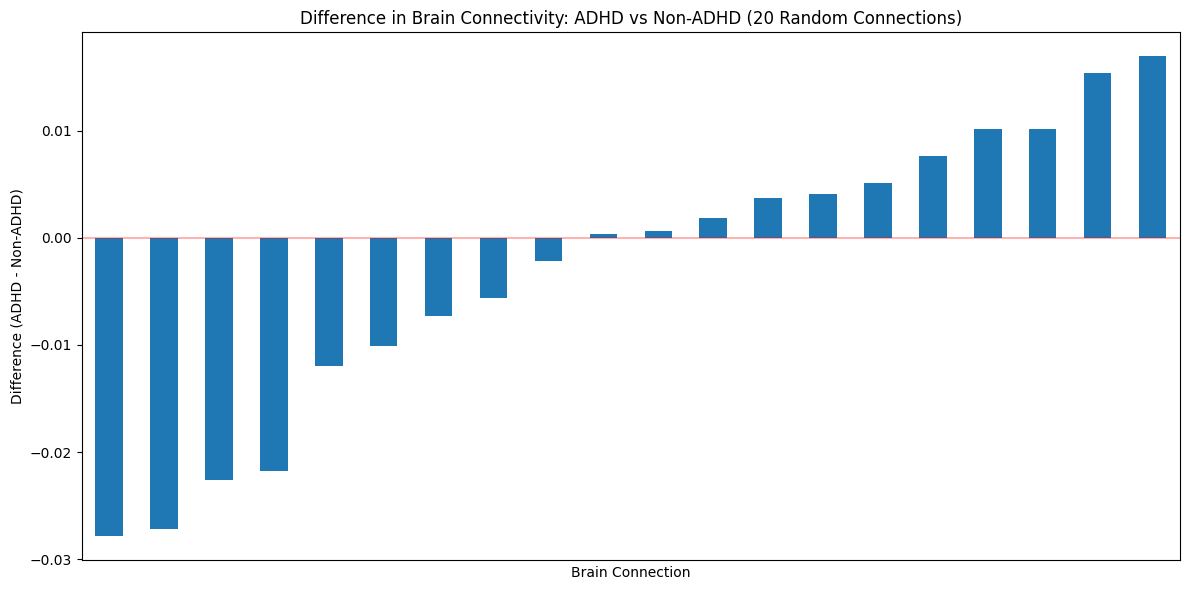

In [45]:
plt.figure(figsize=(12, 6))
diff.sort_values().plot(kind='bar')
plt.title('Difference in Brain Connectivity: ADHD vs Non-ADHD (20 Random Connections)')
plt.xlabel('Brain Connection')
plt.ylabel('Difference (ADHD - Non-ADHD)')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xticks([])  # Hide feature names to avoid clutter
plt.tight_layout()
plt.show()




### Modelling

In [46]:
train_cols = set(train_df.columns)
test_cols = set(test_df.columns)

missing_in_test = train_cols - test_cols
missing_in_train = test_cols - train_cols

print("Missing in test:", missing_in_test)
print("Missing in train:", missing_in_train)


Missing in test: {'Sex_F', 'ADHD_Outcome'}
Missing in train: set()


In [47]:
##removing columns from train that is not in test
y_ADHD = train['ADHD_Outcome']
y_Sex = train['Sex_F']

train.drop(columns=['ADHD_Outcome', 'Sex_F'], inplace=True)


## Cross Valildation

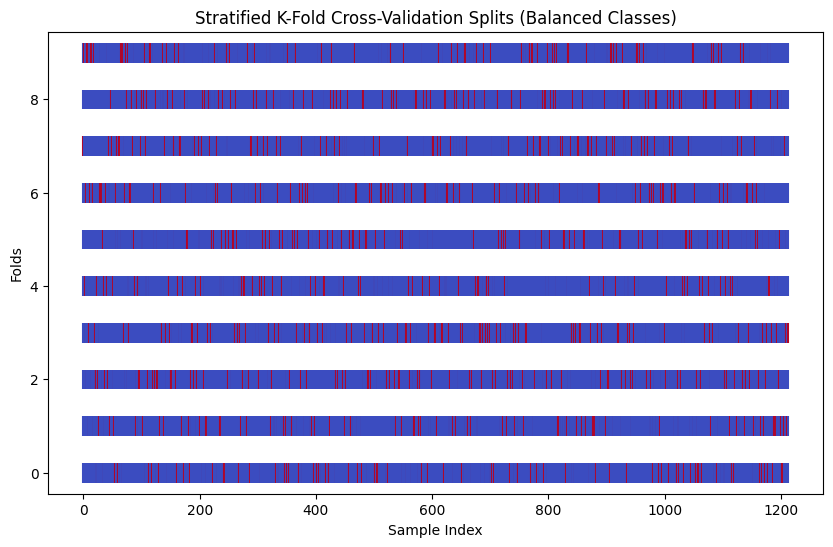

In [48]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

plt.figure(figsize=(10, 6))

for fold, (train_idx, val_idx) in enumerate(skf.split(train, y_ADHD)):
    fold_labels = np.full(len(y_ADHD), np.nan)
    fold_labels[train_idx] = 0  # Training data
    fold_labels[val_idx] = 1  # Validation data

    plt.scatter(range(len(fold_labels)), [fold]*len(fold_labels),
                c=fold_labels, cmap='coolwarm', marker='|', s=200)

plt.xlabel("Sample Index")
plt.ylabel("Folds")
plt.title("Stratified K-Fold Cross-Validation Splits (Balanced Classes)")
plt.show()

In [49]:
# Define scoring metrics
scoring = {
    "Accuracy": "accuracy",
    "Precision": make_scorer(precision_score),
    "Recall": make_scorer(recall_score),
    "F1-Score": make_scorer(f1_score),
    "ROC-AUC": make_scorer(roc_auc_score)
}

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(),
    # "SVM": SVC(probability=True),
    # "KNN": KNeighborsClassifier(),
    # "Naive Bayes": GaussianNB()
}

# Apply cross-validation for all models
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n📌 Model: {name}")
    for metric_name, metric in scoring.items():
        scores = cross_val_score(model, train, y_ADHD, cv=skf, scoring=metric, n_jobs=-1)
        print(f"{metric_name}: {np.mean(scores):.4f}")


📌 Model: Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy: 0.7593


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Precision: 0.8094


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Recall: 0.8484


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

F1-Score: 0.8284


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

ROC-AUC: 0.7069

📌 Model: Random Forest
Accuracy: 0.6785
Precision: 0.6890
Recall: 0.9795
F1-Score: 0.8121
ROC-AUC: 0.5088

📌 Model: Gradient Boosting
Accuracy: 0.7856
Precision: 0.8076


KeyboardInterrupt: 

In [57]:
# Model for ADHD prediction

test_df = test_df[train.columns]

adhd_model = LogisticRegression(max_iter=1000,class_weight='balanced')
adhd_model.fit(train, y_ADHD)
y_test_pred_adhd = adhd_model.predict(test_df)

# Model for Sex prediction
sex_model = LogisticRegression(max_iter=1000,class_weight='balanced')
sex_model.fit(train, y_Sex)
y_test_pred_sex = sex_model.predict(test_df)


In [58]:
submission = pd.DataFrame({
    "participant_id": test_df.index,  
    "ADHD_Outcome": y_test_pred_adhd,
    "Sex_F": y_test_pred_sex
})


submission.to_csv("submission3.csv", index=False)